# Simpsons Character Classifier 

<img src="pic_0003.jpg" style="width:700px;height:400px;">

## Goals:
### 1. Reuse Inception V3 model to train on dog breed data
### 2. Freeze most of the layers
### 3. Cut top layer and add new Fully COnnected layer
### 4. Retrain just top layers 
### 5. EValuate Model


### Import python packages

In [1]:


from keras import regularizers
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation,Dense
from keras.models import Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
from keras.applications import vgg16
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from numpy.random import rand
from keras.callbacks import ModelCheckpoint
import os
# Scikit Imports
from sklearn.model_selection import train_test_split
# Matplot Imports
import matplotlib.pyplot as plt
from keras.models import model_from_json

import seaborn as sns 


Using TensorFlow backend.


In [2]:
# Intialize matplotlib parameters

pd.options.display.max_colwidth = 600


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

## Get Dataset

The Stanford Dog breed dataset is available at [Kaggle/Dogbreed](https://www.kaggle.com/c/dog-breed-identification/data).

The download consists of train, test and label files

In [3]:
train_folder = '/Volumes/My Passport for Mac/data/simpsons/'
test_folder = '/Volumes/My Passport for Mac/data/dog-breeds/test/'

In [4]:
def getImagesFilePathsFromFolder(path):
    files = []
    print("path: " + path )
    for f in listdir(path):
        if( isfile(join(path, f)) and (".jpg" in f)) :
            #print("path: " + path)
            #print("file:" + f)
            #print("path + file", os.path.join(path, f))
            files.append(os.path.join(path, f))  
    return files

### Build dataset of labels and image paths

In [5]:
data_dict = {}
target_labels_list = []
image_path_list = []
counter = 0
fileCounter = 0

walkIterations = 0
for r,d,f in os.walk(train_folder):
    print("Walk Iteration : " + str(walkIterations) )
    print("root : " + r)
    print(" dir: " + str(d))
    print("file: " + str(f))
    if(walkIterations == 0 ):
        walkIterations = walkIterations + 1
        continue
    fileList = getImagesFilePathsFromFolder(r)
    for file in fileList:
        label = file.split("/")[-2]
        image_path = file
        print("file : " + file)
        print("label : " + label)
        print("image_path : " + image_path)
        target_labels_list.append(label)
        image_path_list.append(image_path)
        counter = counter + 1
        fileCounter = fileCounter + 1
    walkIterations = walkIterations + 1
    
                
print(counter)            
data_dict["label"] = target_labels_list            
data_dict["image_path"] = image_path_list
input_df = pd.DataFrame(data_dict)


Walk Iteration : 0
root : /Volumes/My Passport for Mac/data/simpsons/
 dir: ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum', 'homer_simpson', 'lisa_simpson', 'marge_simpson']
file: ['.DS_Store']
Walk Iteration : 1
root : /Volumes/My Passport for Mac/data/simpsons/abraham_grampa_simpson
 dir: []
file: ['pic_0000.jpg', 'pic_0001.jpg', 'pic_0002.jpg', 'pic_0003.jpg', 'pic_0004.jpg', 'pic_0005.jpg', 'pic_0006.jpg', 'pic_0007.jpg', 'pic_0008.jpg', 'pic_0009.jpg', 'pic_0010.jpg', 'pic_0011.jpg', 'pic_0012.jpg', 'pic_0013.jpg', 'pic_0014.jpg', 'pic_0015.jpg', 'pic_0016.jpg', 'pic_0017.jpg', 'pic_0018.jpg', 'pic_0019.jpg', 'pic_0020.jpg', 'pic_0021.jpg', 'pic_0022.jpg', 'pic_0023.jpg', 'pic_0024.jpg', 'pic_0025.jpg', 'pic_0026.jpg', 'pic_0027.jpg', 'pic_0028.jpg', 'pic_0029.jpg', 'pic_0030.jpg', 'pic_0031.jpg', 'pic_0032.jpg', 'pic_0033.jpg', 'pic_0034.jpg', 'pic_0035.jpg', 'pic_0036.jpg', 'pic_0037.jpg', 'pic_0038.jpg', 'pic_0039

Walk Iteration : 2
root : /Volumes/My Passport for Mac/data/simpsons/apu_nahasapeemapetilon
 dir: []
file: ['pic_0000.jpg', 'pic_0001.jpg', 'pic_0002.jpg', 'pic_0003.jpg', 'pic_0004.jpg', 'pic_0005.jpg', 'pic_0006.jpg', 'pic_0007.jpg', 'pic_0008.jpg', 'pic_0009.jpg', 'pic_0010.jpg', 'pic_0011.jpg', 'pic_0012.jpg', 'pic_0013.jpg', 'pic_0014.jpg', 'pic_0015.jpg', 'pic_0016.jpg', 'pic_0017.jpg', 'pic_0018.jpg', 'pic_0019.jpg', 'pic_0020.jpg', 'pic_0021.jpg', 'pic_0022.jpg', 'pic_0023.jpg', 'pic_0024.jpg', 'pic_0025.jpg', 'pic_0026.jpg', 'pic_0027.jpg', 'pic_0028.jpg', 'pic_0029.jpg', 'pic_0030.jpg', 'pic_0031.jpg', 'pic_0032.jpg', 'pic_0033.jpg', 'pic_0034.jpg', 'pic_0035.jpg', 'pic_0036.jpg', 'pic_0037.jpg', 'pic_0038.jpg', 'pic_0039.jpg', 'pic_0040.jpg', 'pic_0041.jpg', 'pic_0042.jpg', 'pic_0043.jpg', 'pic_0044.jpg', 'pic_0045.jpg', 'pic_0046.jpg', 'pic_0047.jpg', 'pic_0048.jpg', 'pic_0049.jpg', 'pic_0050.jpg', 'pic_0051.jpg', 'pic_0052.jpg', 'pic_0053.jpg', 'pic_0054.jpg', 'pic_0055.jp

file : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_0000.jpg
label : bart_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_0000.jpg
file : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_0001.jpg
label : bart_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_0001.jpg
file : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_0002.jpg
label : bart_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_0002.jpg
file : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_0003.jpg
label : bart_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_0003.jpg
file : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_0004.jpg
label : bart_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_0004.jpg
file : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_0005.jpg
label : bart_simpson
image_pa

file : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_1338.jpg
label : bart_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_1338.jpg
file : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_1339.jpg
label : bart_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_1339.jpg
file : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_1340.jpg
label : bart_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_1340.jpg
file : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_1341.jpg
label : bart_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/bart_simpson/pic_1341.jpg
Walk Iteration : 4
root : /Volumes/My Passport for Mac/data/simpsons/charles_montgomery_burns
 dir: []
file: ['pic_0000.jpg', 'pic_0001.jpg', 'pic_0002.jpg', 'pic_0003.jpg', 'pic_0004.jpg', 'pic_0005.jpg', 'pic_0006.jpg', 'pic_0007.jpg', 'pic_0008.jpg', 'pic_0009.jpg', 'pic_0010.jpg'

file : /Volumes/My Passport for Mac/data/simpsons/charles_montgomery_burns/pic_0725.jpg
label : charles_montgomery_burns
image_path : /Volumes/My Passport for Mac/data/simpsons/charles_montgomery_burns/pic_0725.jpg
file : /Volumes/My Passport for Mac/data/simpsons/charles_montgomery_burns/pic_0726.jpg
label : charles_montgomery_burns
image_path : /Volumes/My Passport for Mac/data/simpsons/charles_montgomery_burns/pic_0726.jpg
file : /Volumes/My Passport for Mac/data/simpsons/charles_montgomery_burns/pic_0727.jpg
label : charles_montgomery_burns
image_path : /Volumes/My Passport for Mac/data/simpsons/charles_montgomery_burns/pic_0727.jpg
file : /Volumes/My Passport for Mac/data/simpsons/charles_montgomery_burns/pic_0728.jpg
label : charles_montgomery_burns
image_path : /Volumes/My Passport for Mac/data/simpsons/charles_montgomery_burns/pic_0728.jpg
file : /Volumes/My Passport for Mac/data/simpsons/charles_montgomery_burns/pic_0729.jpg
label : charles_montgomery_burns
image_path : /Volum

label : chief_wiggum
image_path : /Volumes/My Passport for Mac/data/simpsons/chief_wiggum/pic_0765.jpg
file : /Volumes/My Passport for Mac/data/simpsons/chief_wiggum/pic_0766.jpg
label : chief_wiggum
image_path : /Volumes/My Passport for Mac/data/simpsons/chief_wiggum/pic_0766.jpg
file : /Volumes/My Passport for Mac/data/simpsons/chief_wiggum/pic_0767.jpg
label : chief_wiggum
image_path : /Volumes/My Passport for Mac/data/simpsons/chief_wiggum/pic_0767.jpg
file : /Volumes/My Passport for Mac/data/simpsons/chief_wiggum/pic_0768.jpg
label : chief_wiggum
image_path : /Volumes/My Passport for Mac/data/simpsons/chief_wiggum/pic_0768.jpg
file : /Volumes/My Passport for Mac/data/simpsons/chief_wiggum/pic_0769.jpg
label : chief_wiggum
image_path : /Volumes/My Passport for Mac/data/simpsons/chief_wiggum/pic_0769.jpg
file : /Volumes/My Passport for Mac/data/simpsons/chief_wiggum/pic_0770.jpg
label : chief_wiggum
image_path : /Volumes/My Passport for Mac/data/simpsons/chief_wiggum/pic_0770.jpg
fi

label : homer_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_0519.jpg
file : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_0520.jpg
label : homer_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_0520.jpg
file : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_0521.jpg
label : homer_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_0521.jpg
file : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_0522.jpg
label : homer_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_0522.jpg
file : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_0523.jpg
label : homer_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_0523.jpg
file : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_0524.jpg
label : homer_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/homer_simpso

file : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_1905.jpg
label : homer_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_1905.jpg
file : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_1906.jpg
label : homer_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_1906.jpg
file : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_1907.jpg
label : homer_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_1907.jpg
file : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_1908.jpg
label : homer_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_1908.jpg
file : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_1909.jpg
label : homer_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_1909.jpg
file : /Volumes/My Passport for Mac/data/simpsons/homer_simpson/pic_1910.jpg
label : homer

file : /Volumes/My Passport for Mac/data/simpsons/lisa_simpson/pic_0721.jpg
label : lisa_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/lisa_simpson/pic_0721.jpg
file : /Volumes/My Passport for Mac/data/simpsons/lisa_simpson/pic_0722.jpg
label : lisa_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/lisa_simpson/pic_0722.jpg
file : /Volumes/My Passport for Mac/data/simpsons/lisa_simpson/pic_0723.jpg
label : lisa_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/lisa_simpson/pic_0723.jpg
file : /Volumes/My Passport for Mac/data/simpsons/lisa_simpson/pic_0724.jpg
label : lisa_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/lisa_simpson/pic_0724.jpg
file : /Volumes/My Passport for Mac/data/simpsons/lisa_simpson/pic_0725.jpg
label : lisa_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/lisa_simpson/pic_0725.jpg
file : /Volumes/My Passport for Mac/data/simpsons/lisa_simpson/pic_0726.jpg
label : lisa_simpson
image_pa

image_path : /Volumes/My Passport for Mac/data/simpsons/marge_simpson/pic_0522.jpg
file : /Volumes/My Passport for Mac/data/simpsons/marge_simpson/pic_0523.jpg
label : marge_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/marge_simpson/pic_0523.jpg
file : /Volumes/My Passport for Mac/data/simpsons/marge_simpson/pic_0524.jpg
label : marge_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/marge_simpson/pic_0524.jpg
file : /Volumes/My Passport for Mac/data/simpsons/marge_simpson/pic_0525.jpg
label : marge_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/marge_simpson/pic_0525.jpg
file : /Volumes/My Passport for Mac/data/simpsons/marge_simpson/pic_0526.jpg
label : marge_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/marge_simpson/pic_0526.jpg
file : /Volumes/My Passport for Mac/data/simpsons/marge_simpson/pic_0527.jpg
label : marge_simpson
image_path : /Volumes/My Passport for Mac/data/simpsons/marge_simpson/pic_0527.jpg
file : 

In [6]:
input_df.head()

,label,image_path
0,abraham_grampa_simpson,/Volumes/My Passport for Mac/data/simpsons/abraham_grampa_simpson/pic_0000.jpg
1,abraham_grampa_simpson,/Volumes/My Passport for Mac/data/simpsons/abraham_grampa_simpson/pic_0001.jpg
2,abraham_grampa_simpson,/Volumes/My Passport for Mac/data/simpsons/abraham_grampa_simpson/pic_0002.jpg
3,abraham_grampa_simpson,/Volumes/My Passport for Mac/data/simpsons/abraham_grampa_simpson/pic_0003.jpg
4,abraham_grampa_simpson,/Volumes/My Passport for Mac/data/simpsons/abraham_grampa_simpson/pic_0004.jpg


In [7]:
input_df.describe()

,label,image_path
count,9948,9948
unique,8,9948
top,homer_simpson,/Volumes/My Passport for Mac/data/simpsons/chief_wiggum/pic_0788.jpg
freq,2246,1


## Check Number of Classes in the Dataset

The dataset contain 120 different dog breeds

In [8]:
target_labels = input_df['label']
len(set(target_labels))
print(target_labels[0:5])

0    abraham_grampa_simpson
1    abraham_grampa_simpson
2    abraham_grampa_simpson
3    abraham_grampa_simpson
4    abraham_grampa_simpson
Name: label, dtype: object


## Prepare Labels
Deep Learning models work with one hot encoded outputs or target variables. We utilize pandas to prepare one hot encoding for the labels.

In [9]:
labels_ohe_names = pd.get_dummies(target_labels, sparse=True)

print(labels_ohe_names.shape)
labels_ohe = np.asarray(labels_ohe_names)
labels_ohe_names.to_csv("labels.csv")
print(type(labels_ohe_names))
print(labels_ohe.shape)
print(labels_ohe[0:5])
labels_ohe_names.head()

(9948, 8)
<class 'pandas.core.frame.DataFrame'>
(9948, 8)
[[1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]]


,abraham_grampa_simpson,apu_nahasapeemapetilon,bart_simpson,charles_montgomery_burns,chief_wiggum,homer_simpson,lisa_simpson,marge_simpson
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0


We add another column to the labels dataset to identify image path

### Understand Data


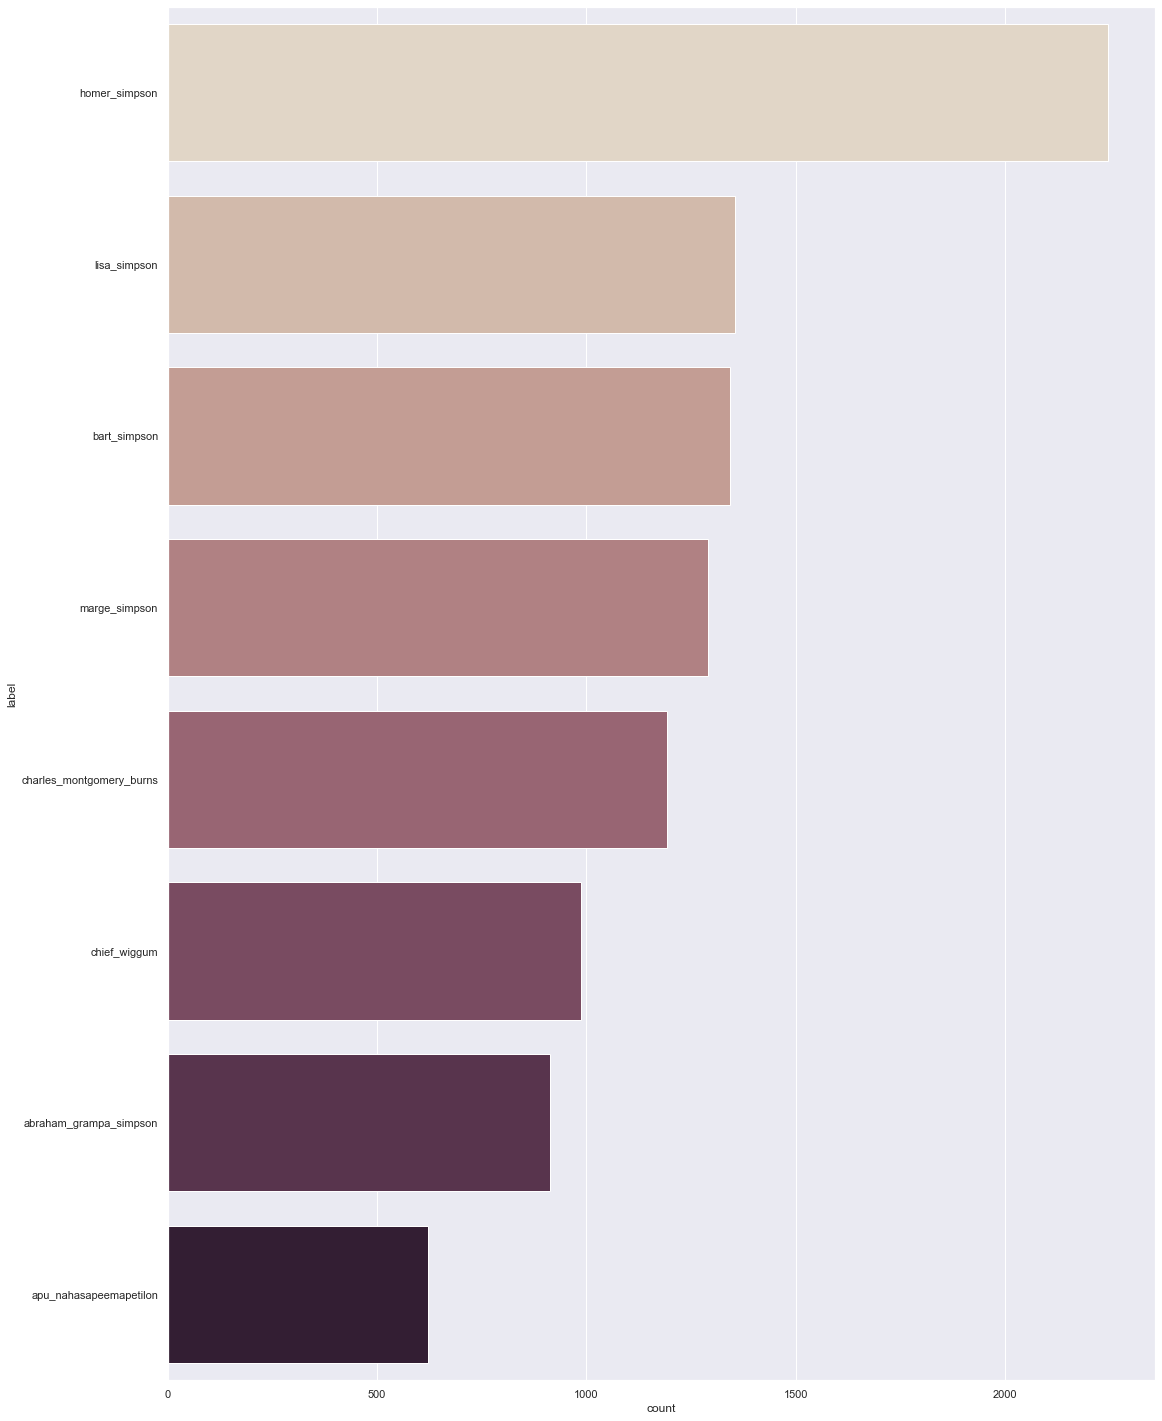

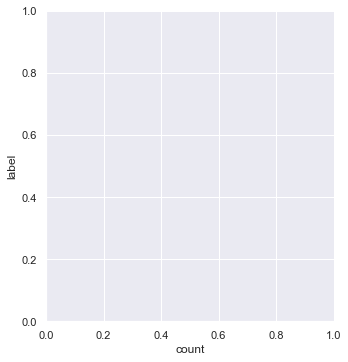

In [10]:
sns.set(style="darkgrid")
sns.set(color_codes=True)
fig, ax = plt.subplots()
fig.set_size_inches(17.7, 25.27)
sns.catplot(y="label",   kind="count", palette="ch:.25",ax=ax, data=input_df, order=input_df.label.value_counts().iloc[:20].index);


## Prepare Train-Test Datasets
We use a 70-30 split to prepare the two dataset. 

In [11]:
train_data = np.array([img_to_array(
                            load_img(img, 
                                     target_size=(299, 299))
                       ) for img 
                           in input_df['image_path'].values.tolist()
                      ]).astype('float32')

In [12]:
train_data.shape

(9948, 299, 299, 3)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    target_labels, 
                                                    test_size=0.3, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

In [14]:
x_train.shape, x_test.shape

((6963, 299, 299, 3), (2985, 299, 299, 3))

Prepare Validation Dataset

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.15, 
                                                    stratify=np.array(y_train), 
                                                    random_state=42)

In [16]:
x_train.shape, x_val.shape

((5918, 299, 299, 3), (1045, 299, 299, 3))

In [17]:
print(y_train.shape)

(5918,)


Prepare target variables for train, test and validation datasets

In [18]:
y_train_ohe = pd.get_dummies(y_train.reset_index(drop=True)).as_matrix()
y_val_ohe = pd.get_dummies(y_val.reset_index(drop=True)).as_matrix()
y_test_ohe = pd.get_dummies(y_test.reset_index(drop=True)).as_matrix()

y_train_ohe.shape, y_test_ohe.shape, y_val_ohe.shape

((5918, 8), (2985, 8), (1045, 8))

## Data Augmentation

Since number of samples per class are not very high, we utilize data augmentation to prepare different variations of different samples available. We do this using the ```ImageDataGenerator utility``` from ```keras```

In [19]:
BATCH_SIZE = 32

In [20]:
# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

In [21]:
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

## Prepare Deep Learning Classifier

* Load InceptionV3 pretrained on ImageNet without its top/classification layer
* Add additional custom layers on top of InceptionV3 to prepare custom classifier

In [22]:
# Get the InceptionV3 model so we can do transfer learning
#base_inception = InceptionV3(weights='imagenet', include_top = False, input_shape=(299, 299, 3))
base_vgg16_model = vgg16.VGG16(weights='imagenet', include_top = False, input_shape=(299, 299, 3))

#print(base_inception.summary())

base_vgg16_model.trainable = True
set_trainable = False
for layer in base_vgg16_model.layers:
    print(layer)
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        print(layer.name)
        print("set trainable as true")
        layer.trainable = True
    else:
        print(layer.name)
        layer.trainable = False
        print("set trainable as false")



input_1
set trainable as false
block1_conv1
set trainable as false
block1_conv2
set trainable as false
block1_pool
set trainable as false
block2_conv1
set trainable as false
block2_conv2
set trainable as false
block2_pool
set trainable as false
block3_conv1
set trainable as false
block3_conv2
set trainable as false
block3_conv3
set trainable as false
block3_pool
set trainable as false
block4_conv1
set trainable as true
block4_conv2
set trainable as true
block4_conv3
set trainable as true
block4_pool
set trainable as true
block5_conv1
set trainable as true
block5_conv2
set trainable as true
block5_conv3
set trainable as true
block5_pool
set trainable as true


In [23]:
# Add a global spatial average pooling layer
out = base_vgg16_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = y_train_ohe.shape[1]
predictions = Dense(total_classes, activation='softmax')(out)

* Stack the two models (InceptionV3 and custom layers) on top of each other 
* Compile the model and view its summary

In [24]:
model = Model(inputs=base_vgg16_model.input, outputs=predictions)

# only if we want to freeze layers
#for layer in base_inception.layers:
#    layer.trainable = False
    
model.summary()
# Compile 
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0   

## Model Training
We train the model with a Batch Size of 32 for just 15 Epochs.

The model utilizes the power of transfer learning to achieve a validation accuracy of about __81%__ !

In [25]:
# Train the model
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=15,
                              callbacks=[checkpoint],
                              verbose=True)

Epoch 1/15
184/184 [==============================] - 1490s 8s/step - loss: 1.1267 - accuracy: 0.5980 - val_loss: 0.1595 - val_accuracy: 0.8945

Epoch 00001: val_loss improved from inf to 0.15950, saving model to model-001-0.598029-0.894531.h5
Epoch 2/15
184/184 [==============================] - 1445s 8s/step - loss: 0.3009 - accuracy: 0.9111 - val_loss: 0.1852 - val_accuracy: 0.9378

Epoch 00002: val_loss did not improve from 0.15950
Epoch 3/15
184/184 [==============================] - 1392s 8s/step - loss: 0.2002 - accuracy: 0.9426 - val_loss: 0.0663 - val_accuracy: 0.9506

Epoch 00003: val_loss improved from 0.15950 to 0.06634, saving model to model-003-0.942576-0.950642.h5
Epoch 4/15
184/184 [==============================] - 1391s 8s/step - loss: 0.1888 - accuracy: 0.9439 - val_loss: 0.2052 - val_accuracy: 0.9595

Epoch 00004: val_loss did not improve from 0.06634
Epoch 5/15
184/184 [==============================] - 1438s 8s/step - loss: 0.1531 - accuracy: 0.9582 - val_loss: 0.

Save the Model

## Visualize Model Performance

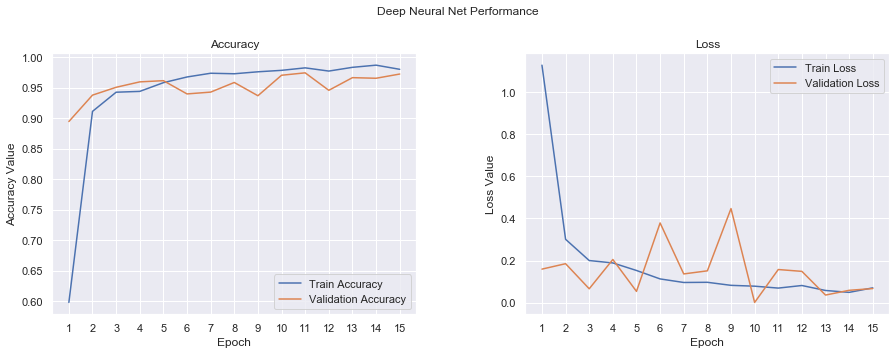

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,16))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Test Model Performance

Step 1 is to prepare the training dataset. Since we scaled training data, test data should also be scaled in a similar manner. 

_Note: Deep Learning models are very sensitive to scaling._

In [27]:
# scaling test features
x_test /= 255.

In [28]:
test_predictions = model.predict(x_test)
test_predictions

array([[8.7210961e-11, 3.6232007e-14, 3.7654532e-12, ..., 8.0449493e-12,
        1.0000000e+00, 1.0064730e-12],
       [2.1591464e-04, 8.3892824e-05, 1.0996655e-03, ..., 1.6928509e-02,
        1.2625746e-03, 9.7936910e-01],
       [2.7110009e-12, 1.2725352e-14, 2.3308955e-11, ..., 4.7819825e-12,
        1.6227006e-13, 1.0736680e-12],
       ...,
       [1.4796277e-11, 2.1031646e-10, 8.4080859e-12, ..., 1.2931545e-10,
        4.4859057e-11, 2.1849179e-11],
       [9.9672312e-01, 2.2832683e-07, 4.0065402e-06, ..., 3.2224683e-03,
        4.2589469e-05, 4.4681101e-06],
       [3.1770727e-05, 2.3415769e-03, 3.2982641e-04, ..., 9.9644607e-01,
        9.9048091e-05, 4.1686582e-07]], dtype=float32)

In [29]:
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
predictions.head()

,abraham_grampa_simpson,apu_nahasapeemapetilon,bart_simpson,charles_montgomery_burns,chief_wiggum,homer_simpson,lisa_simpson,marge_simpson
0,8.721096e-11,3.623201e-14,3.765453e-12,1.703557e-12,6.280281e-13,8.044949e-12,1.000000e+00,1.006473e-12
1,2.159146e-04,8.389282e-05,1.099666e-03,4.360339e-04,6.041788e-04,1.692851e-02,1.262575e-03,9.793691e-01
2,2.711001e-12,1.272535e-14,2.330896e-11,6.317022e-12,1.000000e+00,4.781983e-12,1.622701e-13,1.073668e-12
3,3.189706e-04,2.603635e-05,5.598717e-01,1.625468e-04,2.777379e-05,4.120125e-04,4.390588e-01,1.221204e-04
4,5.738006e-02,4.116253e-03,1.231687e-02,1.374948e-02,9.571569e-03,8.851309e-01,6.986990e-03,1.074782e-02


In [30]:
def get_x_test(img_path, img_height, img_width):
    return np.array([img_to_array(load_img(img_path, target_size=(img_height, img_width)))]).astype('float32')


In [31]:
def predict(x_test, model):
    #x_test = kimage.resize(image, 299, 299) 
    x_test /= 255.0
    test_predictions = model.predict(x_test)
    predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
    predictions = list(predictions.idxmax(axis=1))
    return predictions
    

In [32]:
def getImagesFilePathsFromFolder(path):
    onlyfiles = [ join(path,f) for f in listdir(path) if ( isfile(join(path, f)) and (".jpg" in f) )]
    return onlyfiles

In [33]:
test_labels = list(y_test)
predictions = list(predictions.idxmax(axis=1))
predictions[:10]

['lisa_simpson',
 'marge_simpson',
 'chief_wiggum',
 'bart_simpson',
 'homer_simpson',
 'bart_simpson',
 'charles_montgomery_burns',
 'lisa_simpson',
 'charles_montgomery_burns',
 'apu_nahasapeemapetilon']

In [34]:
MODEL_JSON_PATH = "/Volumes/My Passport for Mac/model/simpsons.json"
MODEL_H5_PATH = "/Volumes/My Passport for Mac/model/simpsons.h5"


# serialize model to JSON
model_json = model.to_json()
with open(MODEL_JSON_PATH, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(MODEL_H5_PATH)
print("Saved model to disk")

Saved model to disk


In [35]:
# load json and create model
json_file = open(MODEL_JSON_PATH, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(MODEL_H5_PATH)
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 


Loaded model from disk


/Volumes/My Passport for Mac/data/simpsons-test/pic_0007.jpg
lisa_simpson
/Volumes/My Passport for Mac/data/simpsons-test/pic_0008.jpg
lisa_simpson
/Volumes/My Passport for Mac/data/simpsons-test/pic_0702.jpg
homer_simpson
/Volumes/My Passport for Mac/data/simpsons-test/pic_0703.jpg
homer_simpson


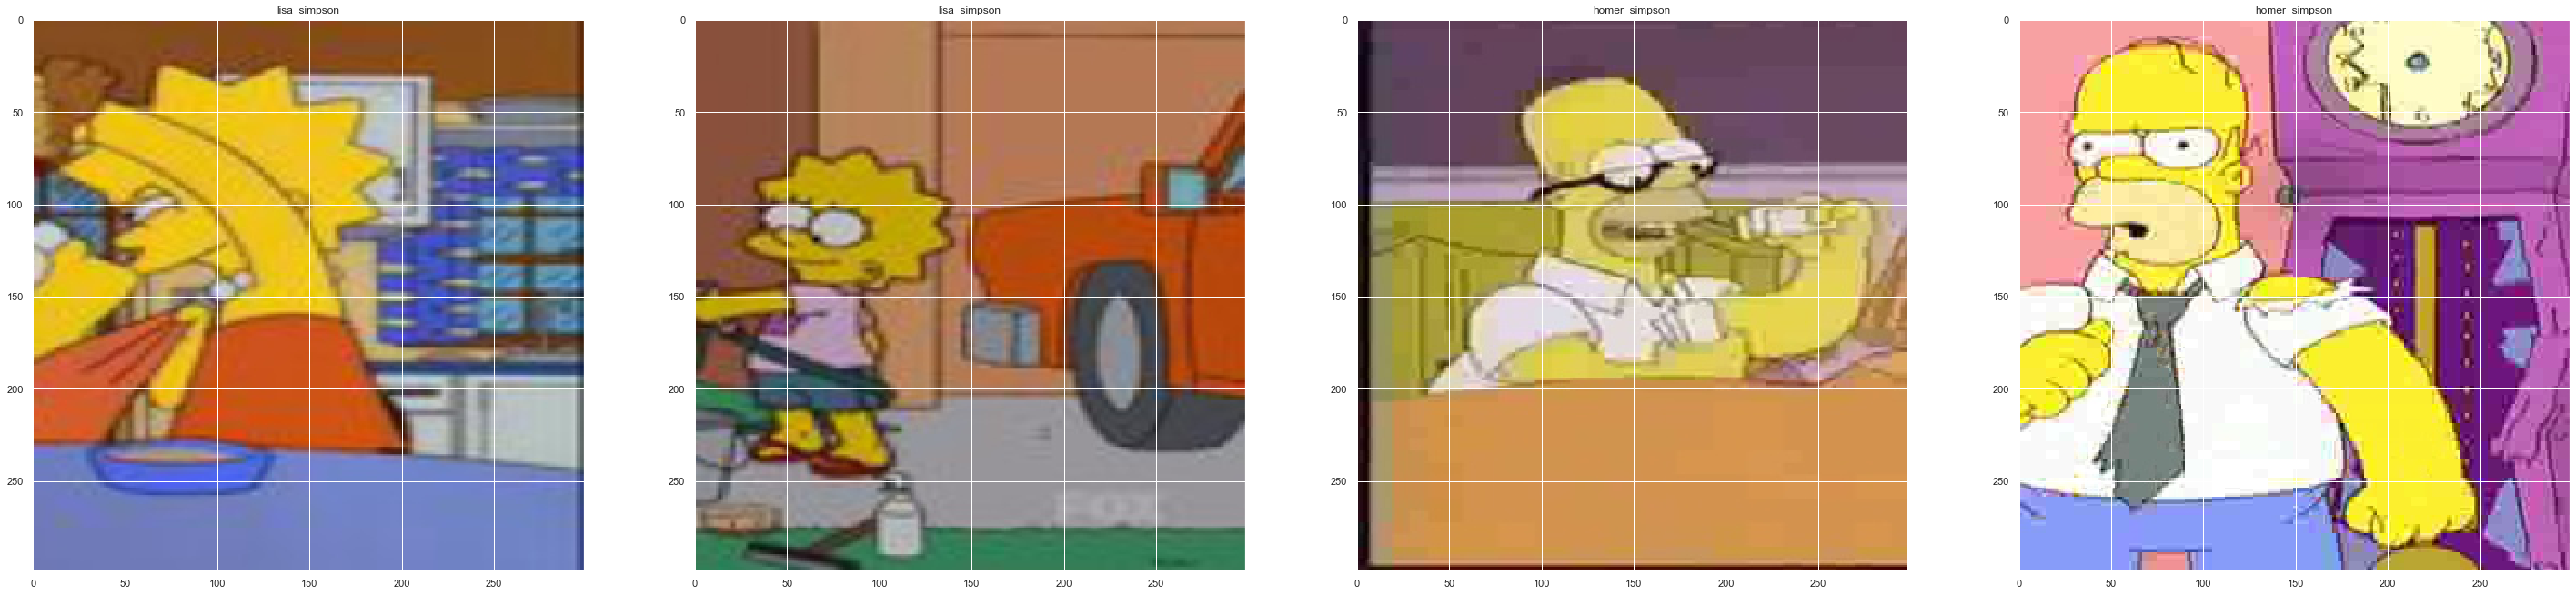

In [36]:
path = "/Volumes/My Passport for Mac/data/simpsons-test"
fileCount = len(getImagesFilePathsFromFolder(path)) 
#print(getImagesFilePathsFromFolder(path))
fig, ax = plt.subplots(1,fileCount, figsize=(50,50))
img_Counter=0;

for img_path in getImagesFilePathsFromFolder(path):
    print(img_path)
    breed = predict(get_x_test(img_path, 299, 299), loaded_model)[0]
    print(breed)
    ax[img_Counter].set_title(breed)
    ax[img_Counter].imshow(load_img(img_path, target_size=(299, 299)))
    img_Counter = img_Counter + 1



## Analyze Test Performance

In [37]:
import model_evaluation_utils as meu

In [38]:
meu.get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)

Accuracy: 0.9772
Precision: 0.9774
Recall: 0.9772
F1 Score: 0.9772


In [39]:
meu.display_classification_report(true_labels=test_labels, 
                                  predicted_labels=predictions, 
                                  classes=list(labels_ohe_names.columns))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.99      0.97      0.98       274
  apu_nahasapeemapetilon       0.97      0.94      0.95       187
            bart_simpson       0.99      0.98      0.98       403
charles_montgomery_burns       0.98      0.97      0.97       358
            chief_wiggum       0.98      0.98      0.98       296
           homer_simpson       0.97      0.98      0.98       674
            lisa_simpson       0.96      1.00      0.98       406
           marge_simpson       0.99      0.98      0.98       387

                accuracy                           0.98      2985
               macro avg       0.98      0.97      0.98      2985
            weighted avg       0.98      0.98      0.98      2985



In [40]:
meu.display_confusion_matrix(true_labels=test_labels, 
                                    predicted_labels=predictions, 
                                    classes=list(labels_ohe_names.columns))

                                             Predicted:  \
                                 abraham_grampa_simpson   
Actual: abraham_grampa_simpson                      265   
        apu_nahasapeemapetilon                        0   
        bart_simpson                                  1   
        charles_montgomery_burns                      0   
        chief_wiggum                                  0   
        homer_simpson                                 1   
        lisa_simpson                                  0   
        marge_simpson                                 0   

                                                                      \
                                 apu_nahasapeemapetilon bart_simpson   
Actual: abraham_grampa_simpson                        2            0   
        apu_nahasapeemapetilon                      175            0   
        bart_simpson                                  0          394   
        charles_montgomery_burns                 

The model achieves a test accuracy of approximately __86%__

## Visualize Model Performance
Visualize model performance with actual images, labels and prediction confidence

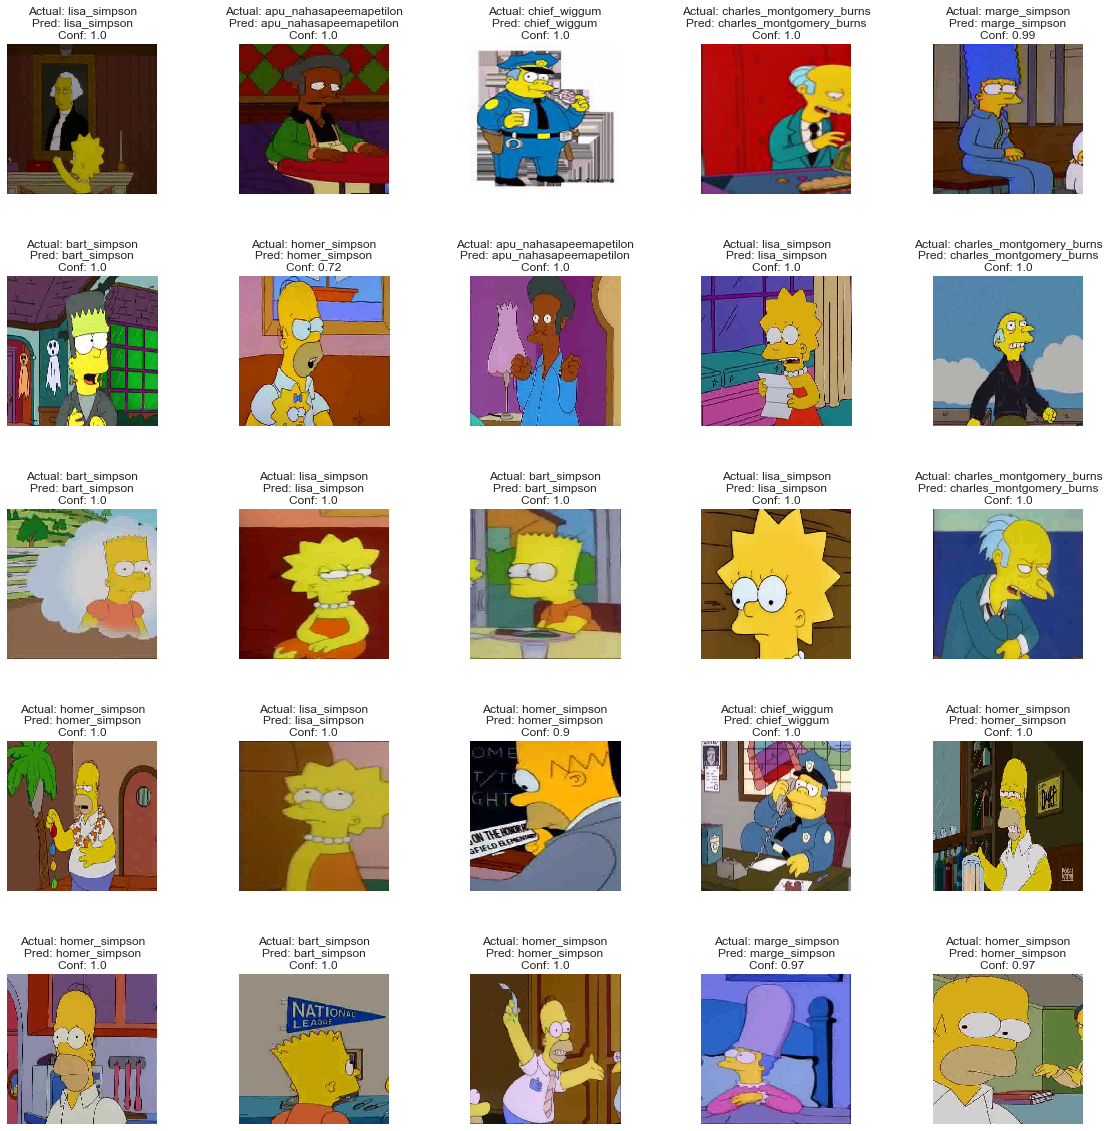

In [41]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)
batch_size = 25
dataset = x_test

label_dict = dict(enumerate(labels_ohe_names.columns.values))
model_input_shape = (1,)+model.get_input_shape_at(0)[1:]
random_batch_indx = np.random.permutation(np.arange(0,len(dataset)))[:batch_size]

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual_label = np.array(y_test)[random_batch_indx[img_idx]]
        prediction = model.predict(dataset[random_batch_indx[img_idx]].reshape(model_input_shape))[0]
        label_idx = np.argmax(prediction)
        predicted_label = label_dict.get(label_idx)
        conf = round(prediction[label_idx], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+actual_label+'\nPred: '+predicted_label + '\nConf: ' +str(conf))
        ax[i][j].imshow(dataset[random_batch_indx[img_idx]])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)    